In [2]:
import numpy as np
import scipy.fft as sp_fft

class JointChannelOF:

    def __init__(self, templates, noise_psds, sampling_frequency):
        """
        templates: list of 1D numpy arrays, one per channel
        noise_psds: list of 1D numpy arrays, one per channel
        """
        self._sampling_frequency = sampling_frequency
        self._n_channels = len(templates)
        self._length = len(templates[0])

        self.set_templates(templates)
        self.set_noise_psds(noise_psds)

    def set_templates(self, templates):
        self._templates = templates
        self._template_ffts = [sp_fft.rfft(tpl) / self._sampling_frequency for tpl in templates]
        self._update_kernels()

    def set_noise_psds(self, noise_psds):
        self._noise_psds = noise_psds

        self._inv_psds = []
        for psd in noise_psds:
            inv_psd = np.zeros_like(psd)
            inv_psd[1:] = 1.0 / (psd[1:] + 1e-30)
            if self._length % 2 == 0:
                inv_psd[-1] = 1.0 / (psd[-1] + 1e-30)
            inv_psd[0] = 0.0
            self._inv_psds.append(inv_psd)

        self._update_kernels()

    def _update_kernels(self):
        if hasattr(self, '_template_ffts') and hasattr(self, '_inv_psds'):
            self._kernels = []
            norms = []
            for tpl_fft, inv_psd in zip(self._template_ffts, self._inv_psds):
                kernel = tpl_fft.conjugate() * inv_psd
                norm = np.real(np.sum(kernel * tpl_fft)) * self._sampling_frequency / self._length
                self._kernels.append(kernel)
                norms.append(norm)

            self._kernel_normalization = np.sum(norms)

    def fit_with_shift(self, traces, allowed_shift_range=[-2000, 2000]):
        """
        traces: list of 1D numpy arrays, one per channel
        """
        filtered_traces_fft = []
        trace_ffts = []
        chisq0_total = 0.0

        for trace, kernel, norm, inv_psd in zip(
            traces, self._kernels,
            [np.real(np.sum(k * t)) * self._sampling_frequency / self._length for k, t in zip(self._kernels, self._template_ffts)],
            self._inv_psds
        ):
            tr_fft = sp_fft.rfft(trace) / self._sampling_frequency
            trace_ffts.append(tr_fft)
            filtered = kernel * tr_fft / norm
            filtered_traces_fft.append(filtered)

            chisq0 = np.real(np.vdot(tr_fft, tr_fft * inv_psd)) * self._sampling_frequency / self._length
            chisq0_total += chisq0

        # Sum of inverse FFTs of all channels => joint A(t0)
        amp_series = 0.5 * sum(sp_fft.irfft(filt) * self._sampling_frequency for filt in filtered_traces_fft)

        chisq_series = chisq0_total - amp_series**2 * self._kernel_normalization

        if allowed_shift_range is None:
            ind = np.arange(len(chisq_series))
        else:
            start = (self._length + allowed_shift_range[0]) % self._length
            stop = (allowed_shift_range[1] + 1) % self._length
            if start < stop:
                ind = np.arange(start, stop)
            else:
                ind = np.concatenate((np.arange(start, self._length), np.arange(0, stop)))

        best_ind = ind[np.argmin(chisq_series[ind])]
        amp = amp_series[best_ind]
        chisq = chisq_series[best_ind] / (self._length - 3)
        t0 = best_ind if best_ind < self._length // 2 else best_ind - self._length

        return amp, chisq, t0


In [3]:
from OF_trigger import *
from trace_IO import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

sampling_frequency = 3906250
template = np.load("../templates/template_K_alpha_no_baseline.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")

# Initialize Optimum Filter
trigger = OFtrigger(template, noise_psd, sampling_frequency)



Processing energies: 100%|██████████| 30/30 [05:59<00:00, 11.99s/it]


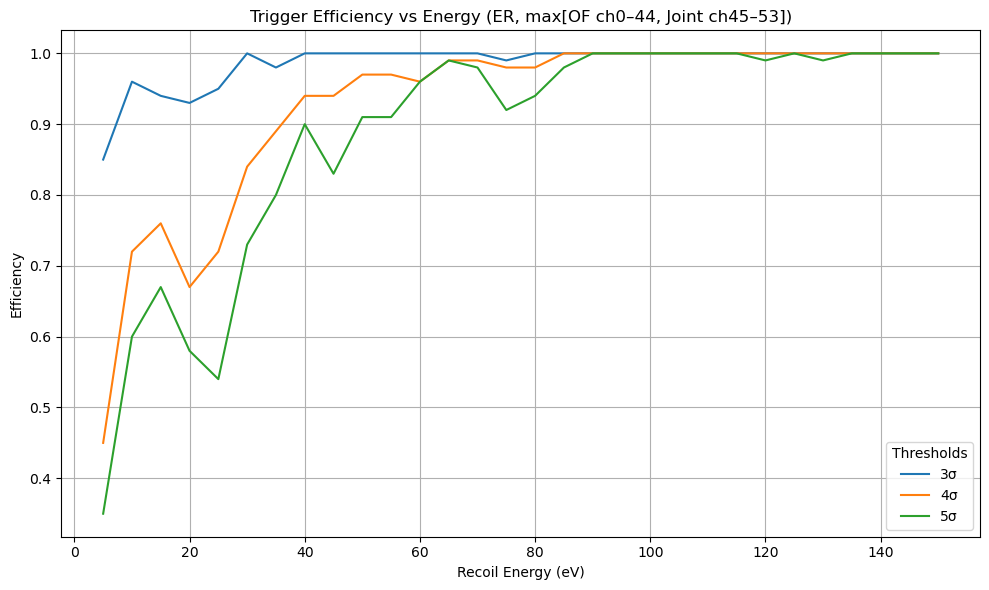

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

fs = 3906250
sigma = 0.7674
thresholds = [round(n * sigma, 4) for n in [3, 4, 5]]
energy_values = list(range(5, 151, 5))
pass_rates_by_threshold = {th: [] for th in thresholds}
n_sets = 100

# Load templates and noise PSD
ch45_template = np.load("../templates/vac_templates/vac_ch45_low_eng.npy")
ch46_template = np.load("../templates/vac_templates/vac_ch46plus_low_eng.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")

joint_templates = [ch45_template] + [ch46_template] * 8
joint_psds = [noise_psd] * 9

for energy in tqdm(energy_values, desc="Processing energies"):
    trace_path = f"/ceph/dwong/trigger_samples/ER/traces_energy_{energy}.zst"
    loaded_traces = load_traces_from_zstd(trace_path, n_traces=n_sets)  # shape: (n_sets, 54, trace_length)

    final_amplitudes = []

    for i in range(n_sets):
        full_trace = loaded_traces[i]  # shape: (54, trace_length)

        # ---------- Channels 0–44 ----------
        traces_subset = full_trace[:45]
        results = [trigger.fit_with_shift(trace) for trace in traces_subset]
        amps = np.array([res[0] for res in results])
        max_amp_0_44 = np.max(amps)

        # ---------- Channels 45–53 ----------
        trace_vacuum = full_trace[45:]  # shape: (9, trace_length)
        joint_of = JointChannelOF(joint_templates, joint_psds, sampling_frequency=fs)
        amp_joint, chisq_joint, t0_joint = joint_of.fit_with_shift(trace_vacuum)

        # ---------- Combine ----------
        final_amp = max(max_amp_0_44, amp_joint)
        final_amplitudes.append(final_amp)

    final_amplitudes = np.array(final_amplitudes)

    for th in thresholds:
        pass_rate = np.sum(final_amplitudes > th) / n_sets
        pass_rates_by_threshold[th].append(pass_rate)

# ---------- Plotting ----------
sigma_labels = {thresholds[0]: '3σ', thresholds[1]: '4σ', thresholds[2]: '5σ'}

plt.figure(figsize=(10, 6))
for th in thresholds:
    plt.plot(energy_values, pass_rates_by_threshold[th], label=sigma_labels[th])

plt.xlabel('Recoil Energy (eV)')
plt.ylabel('Efficiency')
plt.title('Joint+individual Trigger Efficiency vs Energy(NR))')
plt.legend(title='Thresholds')
plt.grid(True)
plt.tight_layout()
plt.show()


Processing energies: 100%|██████████| 30/30 [05:32<00:00, 11.08s/it]


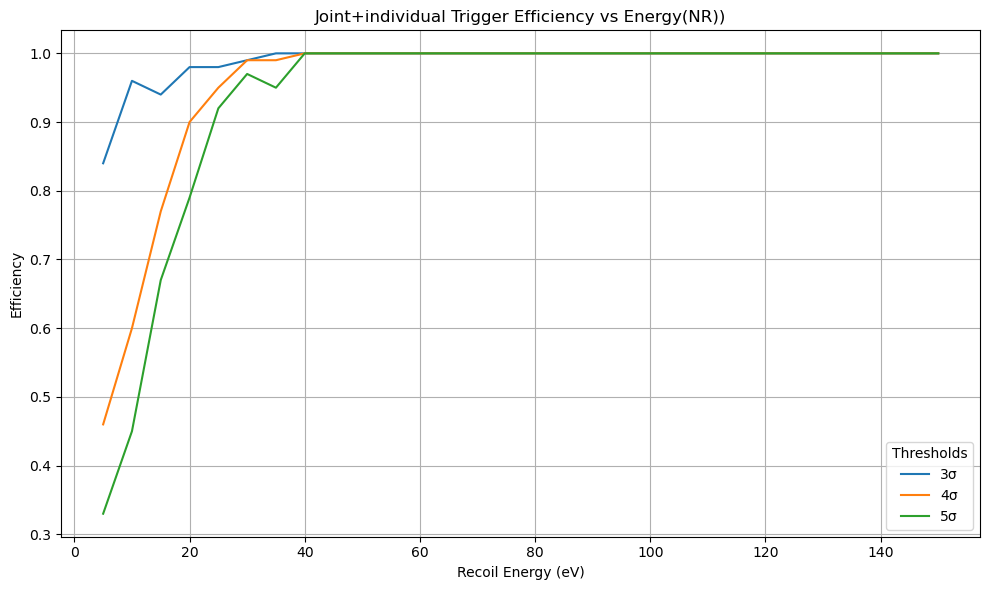

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

fs = 3906250
sigma = 0.7674
thresholds = [round(n * sigma, 4) for n in [3, 4, 5]]
energy_values = list(range(5, 151, 5))
pass_rates_by_threshold = {th: [] for th in thresholds}
n_sets = 100

# Load templates and noise PSD
ch45_template = np.load("../templates/vac_templates/vac_ch45_low_eng.npy")
ch46_template = np.load("../templates/vac_templates/vac_ch46plus_low_eng.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")

joint_templates = [ch45_template] + [ch46_template] * 8
joint_psds = [noise_psd] * 9

for energy in tqdm(energy_values, desc="Processing energies"):
    trace_path = f"/ceph/dwong/trigger_samples/NR/traces_energy_{energy}.zst"
    loaded_traces = load_traces_from_zstd(trace_path, n_traces=n_sets)  # shape: (n_sets, 54, trace_length)

    final_amplitudes = []

    for i in range(n_sets):
        full_trace = loaded_traces[i]  # shape: (54, trace_length)

        # ---------- Channels 0–44 ----------
        traces_subset = full_trace[:45]
        results = [trigger.fit_with_shift(trace) for trace in traces_subset]
        amps = np.array([res[0] for res in results])
        max_amp_0_44 = np.max(amps)

        # ---------- Channels 45–53 ----------
        trace_vacuum = full_trace[45:]  # shape: (9, trace_length)
        joint_of = JointChannelOF(joint_templates, joint_psds, sampling_frequency=fs)
        amp_joint, chisq_joint, t0_joint = joint_of.fit_with_shift(trace_vacuum)

        # ---------- Combine ----------
        final_amp = max(max_amp_0_44, amp_joint)
        final_amplitudes.append(final_amp)

    final_amplitudes = np.array(final_amplitudes)

    for th in thresholds:
        pass_rate = np.sum(final_amplitudes > th) / n_sets
        pass_rates_by_threshold[th].append(pass_rate)

# ---------- Plotting ----------
sigma_labels = {thresholds[0]: '3σ', thresholds[1]: '4σ', thresholds[2]: '5σ'}

plt.figure(figsize=(10, 6))
for th in thresholds:
    plt.plot(energy_values, pass_rates_by_threshold[th], label=sigma_labels[th])

plt.xlabel('Recoil Energy (eV)')
plt.ylabel('Efficiency')
plt.title('Joint+individual Trigger Efficiency vs Energy(NR))')
plt.legend(title='Thresholds')
plt.grid(True)
plt.tight_layout()
plt.show()


Loading noise (E=0) traces for FPR...
Loading signal traces for 25 eV...
Loading signal traces for 50 eV...
Loading signal traces for 75 eV...
Loading signal traces for 100 eV...


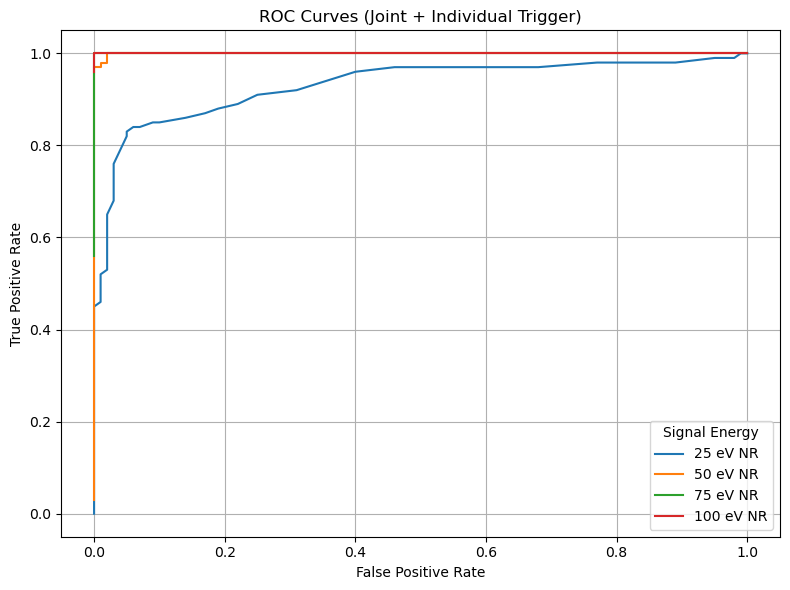

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

fs = 3906250
n_sets = 100
thresholds = np.linspace(0, 15, 300)  # Fine-grained amplitude thresholds

energies_signal = [25, 50, 75, 100]   # NR energies for ROC curves
pass_rates_signal = {E: [] for E in energies_signal}
pass_rates_noise = []  # For E = 0 (background)

# Load templates and noise PSD
ch45_template = np.load("../templates/vac_templates/vac_ch45_low_eng.npy")
ch46_template = np.load("../templates/vac_templates/vac_ch46plus_low_eng.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")

joint_templates = [ch45_template] + [ch46_template] * 8
joint_psds = [noise_psd] * 9

def compute_amplitudes(traces):
    final_amplitudes = []
    for i in range(len(traces)):
        full_trace = traces[i]

        # Channels 0–44
        traces_subset = full_trace[:45]
        results = [trigger.fit_with_shift(trace) for trace in traces_subset]
        max_amp_0_44 = np.max([res[0] for res in results])

        # Channels 45–53 (joint OF)
        trace_vacuum = full_trace[45:]
        joint_of = JointChannelOF(joint_templates, joint_psds, sampling_frequency=fs)
        amp_joint, chisq_joint, t0_joint = joint_of.fit_with_shift(trace_vacuum, allowed_shift_range=[0, 0])

        final_amplitudes.append(max(max_amp_0_44, amp_joint))
    return np.array(final_amplitudes)

# ---- Get noise (E=0) amplitudes ----
print("Loading noise (E=0) traces for FPR...")
noise_traces = load_traces_from_zstd("/ceph/dwong/trigger_samples/NR/traces_energy_0.zst", n_traces=n_sets)
noise_amplitudes = compute_amplitudes(noise_traces)

# ---- Loop over signal energies ----
for energy in energies_signal:
    print(f"Loading signal traces for {energy} eV...")
    signal_traces = load_traces_from_zstd(f"/ceph/dwong/trigger_samples/NR/traces_energy_{energy}.zst", n_traces=n_sets)
    signal_amplitudes = compute_amplitudes(signal_traces)

    for th in thresholds:
        tpr = np.sum(signal_amplitudes > th) / n_sets
        if energy == energies_signal[0]:  # Only once for FPR
            fpr = np.sum(noise_amplitudes > th) / n_sets
            pass_rates_noise.append(fpr)
        pass_rates_signal[energy].append(tpr)

# ---- Plotting ROC curves ----
plt.figure(figsize=(8, 6))
for energy in energies_signal:
    plt.plot(pass_rates_noise, pass_rates_signal[energy], label=f'{energy} eV NR')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Joint + Individual Trigger)')
plt.legend(title='Signal Energy')
plt.grid(True)
plt.tight_layout()
plt.show()
